Author: Hexin Liang
Date Created: 2023/07/04

The purpose of this code is to investigate how nonlinear choice selectivity (switch signal) contributes to the population encoding of choice history, which is fundamental for flexible decision-making. We first generated surrogate neural data that have different population encoding properties of linear and nonlinear choice selectivty, and then decode the choice history across two successive trials. 

The detailed procedures are as follows:
1. Split the experimental data into two halves, one half as training data, the other half as        testing data and for generating surrogate data.
2. Apply linear SVM to the training data, to classify the current choice, the previous choice,      switch or stay, and 4-way classification of the choice sequence across two successive trials.
3. Generate surrogate data: 
   1) Gaussianize the spike counts data by rank transforming the spike counts and applying the         inverse of the CDF for a normal distribution . 
   2) Fit a linear regression model to the gaussianized neural activity, obtained the regression       coefficients for each task variable and the residual sum of squares (RSS) for each neuron. 
   3) Perform three different types of manipulation to generate surrogate data. 
       a) Keep the original regression coefficients.
       b) Remove the switch signal by setting the regression coefficient of the switch variable             to be 0 for each neuron.
       c) Change the correlation structure between the switch and the current choice. Shuffle the           regression coefficients of the switch signal across neurons, so that its correlation             with the regression coefficients of the current choice takes the target value, ranging           from the range [-1, 1]. 
       We then multiply the new design matrix with the same task variables, and plus a gaussian          noise with variance equals RSS. This generates neural activities with designed encoding          properties in a gaussianized form. 
   4) Rank transform the neural activity from 3) back to the spike counts following the original       distribution in the experimental data. 
4. Calculated the decoding accuracy for the experimental testing data, and three types of            surrogate that are generated from the experimental data. 


In [1]:
import mat4py
import pandas as pd
import numpy as np
import scipy
import scipy.io as sio
import math
import warnings
import warnings
import time
from itertools import combinations
from itertools import product

from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
# load preprocessed behavioral + neural data (matlab file)

# probablistic reversal learning taskdata = mat4py.loadmat('C:/Users/liang/Documents/GitHub/ChoiceInteraction/PRL_all_-500_500_250_1500_spkcounts_norm0.mat')
PRL = pd.DataFrame.from_dict(data['Data'])
Var = data['Var']
varName = { i : Var[i] for i in range(len(Var)) }
PRL.rename(columns=varName,inplace=True)
PRL.dropna(inplace=True)
ts = PRL.shape[1] - len(Var)
PRL_regressors = ['Loc','PreLoc','RL','PRL','LocInter','Col','PreCol','RC','PRC','ColInter',
    'Rwd','PreRwd','POS','ChosenMag','UnchosenMag','LMag','HVL','SwitchHVL']

# matching pennies task
data = mat4py.loadmat('C:/Users/liang/Documents/GitHub/ChoiceInteraction/MP_all_-500_500_250_1500_spkcounts_norm0.mat')
MP = pd.DataFrame.from_dict(data['Data'])
Var = data['Var']
varName = { i : Var[i] for i in range(len(Var)) }
MP.rename(columns=varName,inplace=True)
MP.dropna(inplace=True)
MP_regressors = ['Loc','PreLoc','RL','PRL','LocInter','Rwd','PreRwd']

In [3]:
def split_data(data, var1, var2, var3='PreRwd'):
    
    """
    Half-split the experimental data for all the behavioral conditions defined by var1, var2, var3
    
    Args:
        data: pandas dataframe, has all the behavioral and neural data from a task;
              each row includes the spike counts of one neuron throughout different epochs within one trial,
              and the corresponding behavioral variables, and recording details from that trial.
        var1, var2: task variables
        
    Returns:
        train: one half of the data
        test: the other half
    
    """
    
    data.reset_index(inplace=True,drop=True)  
    cell_num = data.cellid.unique()
    kf = KFold(n_splits=2, shuffle=True)
    train_ind = np.array([])
    test_ind = np.array([])
    
    for var1_ind,val1 in enumerate(np.unique(data[var1])):  
        for var2_ind,val2 in enumerate(np.unique(data[var2])):
            for var3_ind,val3 in enumerate(np.unique(data[var3])):

                temp = data[(data[var1]==val1) & (data[var2]==val2) & (data[var3]==val3)]

                for c in range(cell_num.size):
                    
                    cData = temp[temp.cellid==cell_num[c]]
                    trialNum = np.array(cData.index)

                    c_train_ind, c_test_ind = list(kf.split(trialNum))[0]
                    train_ind = np.append(train_ind, trialNum[c_train_ind])
                    test_ind = np.append(test_ind, trialNum[c_test_ind])

    train = data.iloc[train_ind,:]
    test = data.iloc[test_ind,:]
    train.reset_index(inplace=True,drop=True)
    test.reset_index(inplace=True,drop=True)   
    
    return train, test


In [4]:
def create_pseudotrial(data, var1, var2, var3='PreRwd', trialNum=100):
    
    """
    Generate psuedo-trials. Because most of the neurons were collected from separate sessions, here we resample the neural
    activity from individual neurons under the same behavioral condition and construct a population activity for one trial
    as if these neurons were recorded simultaneously. 
    
    Args:
        var1, var2: choice variable, 'Col' for target color or 'Loc' for target location
        res: residual sum of errors from function 'calculate_coef'
        
    Returns:
       A matrix of size Trials*Timestamps*Neurons + the corresponding labels of variables
    """
    
    cell_num = data.cellid.unique()
    pseudotrial = np.zeros([2,2,2,trialNum,ts,cell_num.size+3])  # number of unique values for var1, var2, var3 
    
    for var1_ind,val1 in enumerate(np.unique(data[var1])):  
        for var2_ind,val2 in enumerate(np.unique(data[var2])):
            for var3_ind,val3 in enumerate(np.unique(data[var3])):

                temp = data[(data[var1]==val1) & (data[var2]==val2) & (data[var3]==val3)]

                for c in range(cell_num.size):
                    
                    cData = temp[temp.cellid==cell_num[c]]
                    index = np.random.randint(cData.shape[0],size=trialNum)
                    c_pseudo = cData.iloc[index]
                    pseudotrial[var1_ind,var2_ind,var3_ind,:,:,c] = c_pseudo[c_pseudo.columns[-ts:]].to_numpy()

                pseudotrial[var1_ind,var2_ind,var3_ind,:,:,-3:] = [val1,val2,val1*val2]


    return pseudotrial.reshape((-1,ts,cell_num.size+3))


In [5]:
def calculate_coef(data, regressors, timestamps):

    """
    Apply multiple linear regression model to the spike counts data to examine how single neurons were modulated 
    by the main task variables and the high-level interaction terms among these task variables. 
    
    Args:
        regressors: independent variables for the regression model
        timestamps: the specific epochs to analyze
        
    Returns:
        coef: regression coefficients for [each neuron, each regressor, each epoch]
        res: residual sum of errors for [each neuron, each epoch]
                
    """
    
    cell_num = data.cellid.unique().size   
    coef = np.zeros((cell_num,len(regressors)+1,len(timestamps)))
    residual = np.zeros((cell_num,len(timestamps)))
    clf = linear_model.LinearRegression()

    for c in range(1,cell_num+1):

        cData = data[(data['cellid']==c)] 
        F = cData.loc[:,regressors].to_numpy()
        
        for time_ind, t in enumerate(timestamps):
        
            FR = cData[cData.columns[-ts:]].to_numpy()[:,t]

            FR_sorted = np.sort(FR)
            ind = np.argsort(FR)
            FR_g = np.random.normal(size=len(FR_sorted))
            FR_g_sorted = np.sort(FR_g)
            FR_t = np.zeros(len(FR_sorted))
            FR_t[ind] = FR_g_sorted

            clf.fit(F, FR_t)
            coef[c-1,:,time_ind] = np.append(clf.intercept_,clf.coef_)
            residual[c-1,time_ind] = np.var(FR_t-np.dot(F,coef[c-1,1:,time_ind])-coef[c-1,0,time_ind])
                
    param = {'coef': coef, 
                'res': residual} 
                
    return param

In [6]:
def coef_manipulation(original_coef, regressors, var, coefmode, corr, timestamps): 
    
    """
    Manipulate the regression coefficients for the nonlinear choice selectivity (switch) obtained from the linear regression model,
    and then generate surrogate neural activity with designed population encoding properties of choice-related signals.
    There are two types of manipulations (coefmode):
    1) 'Removal', removal/lesion of the switch signal. 
    2) 'Correlated', shuffle the regression coefficients of switch across neural population, so that the population activity patterns 
       evoked by switch and choice are correlated, and takes the targeted value (corr). 
    
    Args:
        original_coef: regression coefficients obtained from function 'calculate_coef'
        regressors: independent variables for the regression model
        var: choice variable, 'Col' for target color or 'Loc' for target location
        coefmode: 'Removal' or 'Correlated'
        corr: [-1,1], targeted correlation coefficient if coefmode=='Correlated'
        
    Returns:
        manipulated_coef: New design matrix for [each neuron, each regressor, each epoch] after manipulation
                
    """
    
    
    cell_num = original_coef.shape[0] 
    timestamps = original_coef.shape[2] 
    manipulated_coef = original_coef.copy()
    varOI = [var,'Pre'+var,var+'Inter']
    var1_ind = np.where([x==var for x in regressors])[0][0]+1
    var2_ind = np.where([x==var+'Inter' for x in regressors])[0][0]+1
    
    if coefmode == 'Correlated':
                    
        a = np.random.multivariate_normal([0,0],[[1,corr],[corr,1]],size=cell_num)
        a_sorted = np.zeros((cell_num,2))
        var2_reordered = np.zeros(cell_num)

        for time_ind in range(timestamps):
            
            var1_coef = original_coef[:,var1_ind,time_ind]
            var2_coef = original_coef[:,var2_ind,time_ind]

            ind = np.argsort(var1_coef)  
            a_sorted[ind,:] = a[a[:,0].argsort()]

            var2_cellind = np.argsort(a_sorted[:,1])
            var2_sorted = np.sort(var2_coef) 

            manipulated_coef[var2_cellind,var2_ind,time_ind] = var2_sorted
                
    if coefmode == 'Removal':
        manipulated_coef[:,var2_ind,:] = 0
            
    return manipulated_coef

In [7]:
def generate_data(data, coef, residual, regressors, var, timestamps):
    
    """
    Generate surrogate data using the new design matrix / manipulated regression coefficients.
    
    Args:
        coef: manipulated regression coefficients
        residual: residual sum of errors from function 'calculate_coef'
        var: choice variable, 'Col' for target color or 'Loc' for target location
        
    Returns:
        surrogateData: simulated neural activity
        refit_coef:  apply the same regression model again to the surrogate data to examine if the manipulation is valid
                
    """
    
    cell_num = data.cellid.unique().size 
    surrogateData = data.copy()
    Y = np.array([])
    all_index = np.array([])
    varOI = [var,'Pre'+var,var+'Inter']
    refit_coef = np.zeros(coef.shape)

    clf = linear_model.LinearRegression()  
        
    for c in range(1,cell_num+1):

        cData = data[(data['cellid']==c)] 
        F = cData.loc[:,regressors].to_numpy()
        y = np.zeros((len(F),len(timestamps)))
        all_index = np.append(all_index,cData.index.values)
        
        for time_ind, t in enumerate(timestamps):
        
            FR = cData[cData.columns[-ts:]].to_numpy()[:,t]

            y_gaussian = coef[c-1,0,time_ind] + np.dot(F,coef[c-1,1:,time_ind]) + np.random.normal(0, np.sqrt(residual[c-1,time_ind]), len(FR))
            FR_sorted = np.sort(FR)      # sort the original spike counts
            ind = np.argsort(y_gaussian)  # map 
            y[ind,time_ind] = FR_sorted

            clf.fit(F, y[:,time_ind])
            refit_coef[c-1,:,time_ind] = np.append(clf.intercept_,clf.coef_)
                    
        if len(Y) == 0:
            Y = y
        else:
            Y = np.append(Y,y,axis=0)
            
    surrogateData.iloc[all_index.astype(int),-ts+np.array(timestamps)] = Y

    return surrogateData, refit_coef

In [8]:
def decoder_training(train, timestamps):
    
    """
    Apply linear support vector machine on the training data, and store the classifiers.
        
    """
    
    all_clf = [[] for x in range(len(timestamps))]

    for i, t in enumerate(timestamps):
        
        clf1 = SVC(kernel='linear')
        clf2 = SVC(kernel='linear')
        clf3 = SVC(kernel='linear')
        clf4 = SVC(kernel='linear',probability=True) 

        clf1.fit(train[:,t,:-3],train[:,t,-3])
        clf2.fit(train[:,t,:-3],train[:,t,-2])
        clf3.fit(train[:,t,:-3],train[:,t,-1])
        clf4.fit(train[:,t,:-3],train[:,t,-3]*2+train[:,t,-2])
        
        all_clf[i]=[clf1,clf2,clf3,clf4]
        
    return all_clf

In [9]:
def decoder_predict(all_clf, test, timestamps):
    
    """
        
    Returns:
        Accuracy: decoding/classification accuracy for these 4 variables: 
                  current choice, previous choice, switch and choice history across two successive trials.
        Projection: the projection onto the encoding axis of each variable defined by SVM, one data point is one pseudo-trial
    
    """
    
    
    Accuracy = np.zeros((len(timestamps),5))
    Projection = np.zeros((len(timestamps),test.shape[0],7))

    for i, t in enumerate(timestamps):

        clf1=all_clf[i][0]
        clf2=all_clf[i][1]
        clf3=all_clf[i][2]
        clf4=all_clf[i][3]

        Accuracy[i,0] = accuracy_score(clf1.predict(test[:,t,:-3]),test[:,t,-3])
        Accuracy[i,1] = accuracy_score(clf2.predict(test[:,t,:-3]),test[:,t,-2])
        Accuracy[i,2] = accuracy_score(clf3.predict(test[:,t,:-3]),test[:,t,-1])
        Accuracy[i,3] = accuracy_score(clf4.predict(test[:,t,:-3]),test[:,t,-3]*2+test[:,t,-2])
        Accuracy[i,4] = t

        Projection[i,:,0] = test[:,t,-3]
        Projection[i,:,1] = test[:,t,-2]
        Projection[i,:,2] = test[:,t,-1]
        Projection[i,:,3] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf1.coef_))+clf1.intercept_)/LA.norm(clf1.coef_))
        Projection[i,:,4] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf2.coef_))+clf2.intercept_)/LA.norm(clf2.coef_))
        Projection[i,:,5] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf3.coef_))+clf3.intercept_)/LA.norm(clf3.coef_))
        Projection[i,:,6] = t
        
    return Accuracy, Projection

In [10]:
def simulation_accuracy(data, var1, var2, regressors, timestamps, num_iter=10, trialNum=100):
    
    """
    Put all the functions above together, get the decoding accuracy and the projection for
    1) the experimental data, 
    2) simulation with the original regression coefficients,
    3) simulation with the switch signal removed. 
    
    """   
    
    Accuracy = np.zeros((3,num_iter,len(timestamps),6)) # first column, 0 is data, 1 is simulation, 2 is removal
    Projection = np.zeros((3,num_iter,len(timestamps),trialNum*8,8))

    for ii in range(num_iter):
    
        train_data, test_data = split_data(data, var1, var2)
        train_pseudotrial = create_pseudotrial(train_data, var1, var2, trialNum=trialNum)
        test_pseudotrial = create_pseudotrial(test_data, var1, var2, trialNum=trialNum)
        
        test_simulation_param = calculate_coef(test_data, regressors, timestamps)   
        test_simulation, _ = generate_data(test_data, test_simulation_param['coef'], test_simulation_param['res'], regressors, var1, timestamps)
        test_simulation_pseudotrial = create_pseudotrial(test_simulation, var1, var2, trialNum=trialNum)
        
        removal_coef = coef_manipulation(test_simulation_param['coef'], regressors, var1, 'Removal', 0, timestamps)
        test_removal,_ = generate_data(test_data, removal_coef, test_simulation_param['res'], regressors, var1, timestamps)
        test_removal_pseudotrial = create_pseudotrial(test_removal, var1, var2, trialNum=trialNum)
        
        all_clf = decoder_training(train_pseudotrial, timestamps)
        Accuracy[0,ii,:,:-1], Projection[0,ii,:,:,:-1] = decoder_predict(all_clf, test_pseudotrial, timestamps)
        Accuracy[1,ii,:,:-1], Projection[1,ii,:,:,:-1] = decoder_predict(all_clf, test_simulation_pseudotrial, timestamps)
        Accuracy[2,ii,:,:-1], Projection[2,ii,:,:,:-1] = decoder_predict(all_clf, test_removal_pseudotrial, timestamps)
        
    for jj in range(3):
        Accuracy[jj,:,:,-1]=jj
        Projection[jj,:,:,:,-1]=jj
                       
    
    Accuracy_df = pd.DataFrame(data=Accuracy.reshape(-1,6),columns=['Current','Previous','Switch','Choice Sequence','Time','Method'])
    Projection_df = pd.DataFrame(data=Projection.reshape(-1,8),columns=['Current','Previous','Switch','CurrentProjection',
                                                                        'PreviousProjection','SwitchProjection','Time','Method'])
    
    return Accuracy_df, Projection_df


In [11]:
def plot_dataacc(accuracy,task):
    
    """
    Compare the decoding accuracy among three different testing datasets, as described above. 
    
    """    

    plt.close('all')
    fig, axs = plt.subplots(2, 4, figsize=(6,4),facecolor=(1, 1, 1))
    variables = ['Current','Previous','Switch','Choice Sequence']

    if task == 'PRL':
        ticklabels = ['0', '0.5', '1']
        ticks=[[2,4,6],[11,13,15]]
        tlim=[[-1,8],[8,17]]
    else:
        ticklabels = ['0', '0.5']
        ticks=[[2,4],[11,13]]
        tlim=[[0,7],[9,16]]
        
    ticksize=10
    titlesize=12

    for var in range(4):
        
        for ax_ind in range(2):
            
            ax=axs[int(np.floor(var/2)),ax_ind+2*(var%2)]
            sns.lineplot(accuracy[(accuracy.Time>tlim[ax_ind][0]) & (accuracy.Time<tlim[ax_ind][1])],
                         x='Time',y=variables[var],hue='Method',palette=['k','forestgreen','darkviolet'],
                         ax=ax,zorder=2,marker='o',markeredgecolor=None,legend=False)

            ax.set_xticks(ticks[ax_ind])
            ax.set_ylim(0,1.05)
            ax.set_xlim(tlim[ax_ind][0]+1,tlim[ax_ind][1]-1)
                
                
            if ax_ind == 0:

                ax.fill_between([2,4],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['right', 'top']].set_visible(False)
                ax.set_xlabel('Target onset',fontsize=ticksize)
                    
                if var%2==0:
                    ax.set_ylabel('Accuracy (%)')
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels('')
                
            else:
                ax.fill_between([11,13],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['left', 'right', 'top']].set_visible(False)
                ax.set_xlabel('Feedback onset',fontsize=ticksize)
                ax.set_ylabel('')
                ax.set_yticks([])
                
            if var == 3:
                ax.plot(np.array(tlim[ax_ind]),[0.25,0.25],'k--',zorder=1)
            else:
                ax.plot(np.array(tlim[ax_ind]),[0.5,0.5],'k--',zorder=1)     
                
            if var < 2:
                ax.set_xticklabels('')
                ax.set_xlabel('')
            else:
                ax.set_xticklabels(ticklabels,fontsize=ticksize)   
                
            ax.set_position([0.2+0.4*(var%2)+0.17*ax_ind,0.55-0.4*np.floor(var/2),0.15,0.3])
     
        ax.text(10,1.05,variables[var],fontsize=titlesize,ha='center')


    plt.suptitle(task,fontsize=titlesize)


In [171]:
def plot_projection_dist(df,task,method):
    
    if task == 'PRL':
        xlim=[-5,5]
        ylim=[-5,5]
    else:
        xlim=[-30,30]
        ylim=[-10,10]
    
    plt.close('all')
    fig, axs = plt.subplots(2, 2, figsize=(8,8),facecolor=(1, 1, 1))

    ax=axs[0,1]
    ax.axis('off')

    ax=axs[1,0]
    sns.kdeplot(data=df,x='CurrentProjection',y='SwitchProjection',fill=True,thresh=0.5,
                 hue=df[['Current', 'Switch']].apply(tuple, axis=1),ax=ax,legend=False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Choice(t)')
    ax.set_ylabel('Switch')
    ax.set_position([0.2,0.2,0.5,0.5])

    ax=axs[0,0]
    sns.histplot(data=df,x='CurrentProjection',hue='Current',ax=ax,legend=False,
                stat='percent',bins=20,multiple='dodge',element='step')
    ax.set_xlim(xlim)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.spines[['left','bottom','right', 'top']].set_visible(False)
    ax.set_position([0.2,0.7,0.5,0.2])

    ax=axs[1,1]
    sns.histplot(data=df,y='SwitchProjection',hue='Switch',ax=ax,legend=False,
                stat='percent',bins=20,multiple='dodge',element='step')
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.spines[['left','bottom','right', 'top']].set_visible(False)
    ax.set_position([0.7,0.2,0.2,0.5])

    plt.suptitle(task+' '+method)
    plt.savefig(task+' '+method+' '+'Projection')

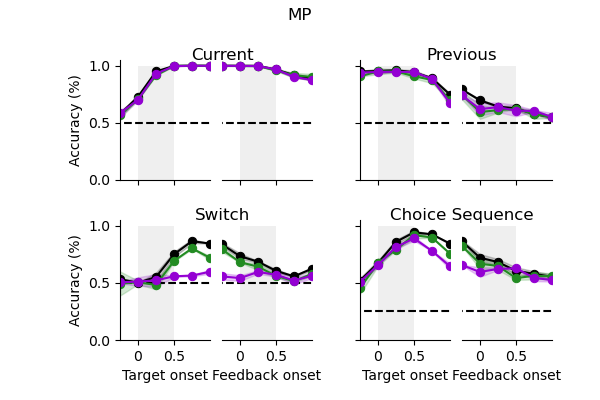

In [14]:
MP_accuracy,MP_projection = simulation_accuracy(MP[MP.area==0],'Loc','PreLoc',MP_regressors,np.arange(18), num_iter=2)
plot_dataacc(MP_accuracy,'MP')

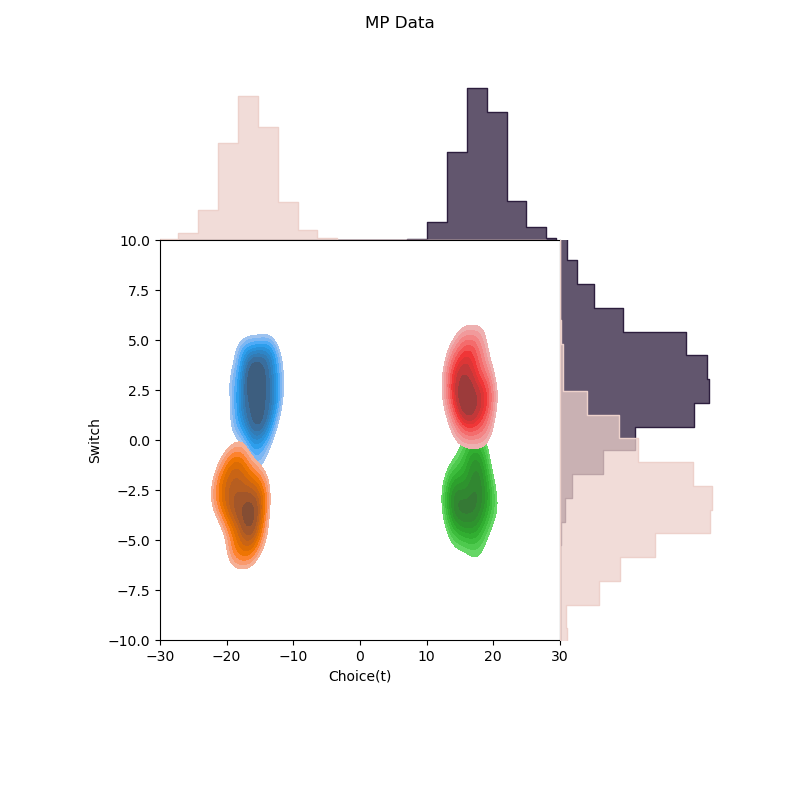

In [172]:
plot_projection_dist(MP_projection[(MP_projection.Time==5)&(MP_projection.Method==0)],'MP', 'Data')